Иморитирование библиотек

In [276]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Смотрим исходные данные

In [277]:
train = pd.read_csv("df/train.csv", low_memory=False)
valid = pd.read_csv("df/valid.csv", low_memory=False)

arr = [train, valid]
names_df = ['train', 'valid']

def perenos():
     if i == 0:
          print('\n*******************************************************************************\n')

for i, elem in enumerate(arr):
     # Вывод info для просмотра типов табл и их колво
     print(f'Инфо {names_df[i]}')
     elem.info()

     # Вывод строк + столб кол-во
     print(f"\n{names_df[i]} имеет: {elem.shape} (строк, столбцов)")

     # Выводим колонки с разными типами данных
     numeric_columns = elem.select_dtypes(include=['int64', 'float64']).columns
     categorical_columns = elem.select_dtypes(include=['object']).columns
     boolean_columns = elem.select_dtypes(include=['bool']).columns

     print(f"\nЧисловые колонки в {names_df[i]}: {len(numeric_columns)}")
     print(f"Категориальные колонки в {names_df[i]}: {len(categorical_columns)}")
     print(f"Булевые колонки в {names_df[i]}: {len(boolean_columns)}")

     perenos()

Инфо train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 2666 entries, report_date to col2663
dtypes: float64(2316), int64(3), object(347)
memory usage: 294.0+ MB

train имеет: (14456, 2666) (строк, столбцов)

Числовые колонки в train: 2319
Категориальные колонки в train: 347
Булевые колонки в train: 0

*******************************************************************************

Инфо valid
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642 entries, 0 to 3641
Columns: 2666 entries, report_date to col2663
dtypes: float64(2329), int64(3), object(334)
memory usage: 74.1+ MB

valid имеет: (3642, 2666) (строк, столбцов)

Числовые колонки в valid: 2332
Категориальные колонки в valid: 334
Булевые колонки в valid: 0


Смотрим пропущенные значения

In [278]:
# Вывод пропущ. знач
for i, elem in enumerate(arr):
    print(f"Число пропущенных значений в {names_df[i]}:")
    print(elem.isna().sum())
    perenos()

Число пропущенных значений в train:
report_date        0
client_id          0
target             0
col1           14453
col2           14450
               ...  
col2659        13950
col2660         6420
col2661         6420
col2662         6420
col2663            0
Length: 2666, dtype: int64

*******************************************************************************

Число пропущенных значений в valid:
report_date       0
client_id         0
target            0
col1           3642
col2           3640
               ... 
col2659        3578
col2660        1280
col2661        1280
col2662        1280
col2663           0
Length: 2666, dtype: int64


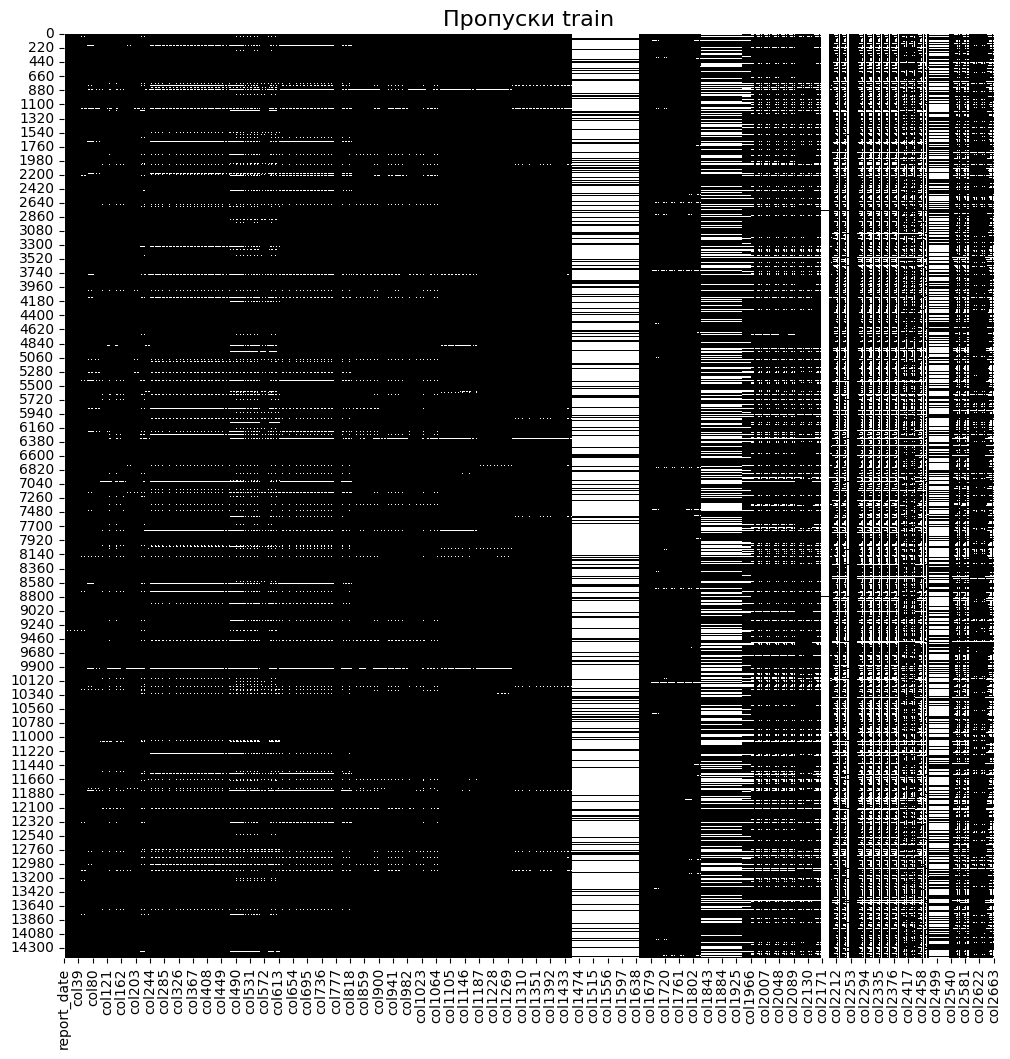

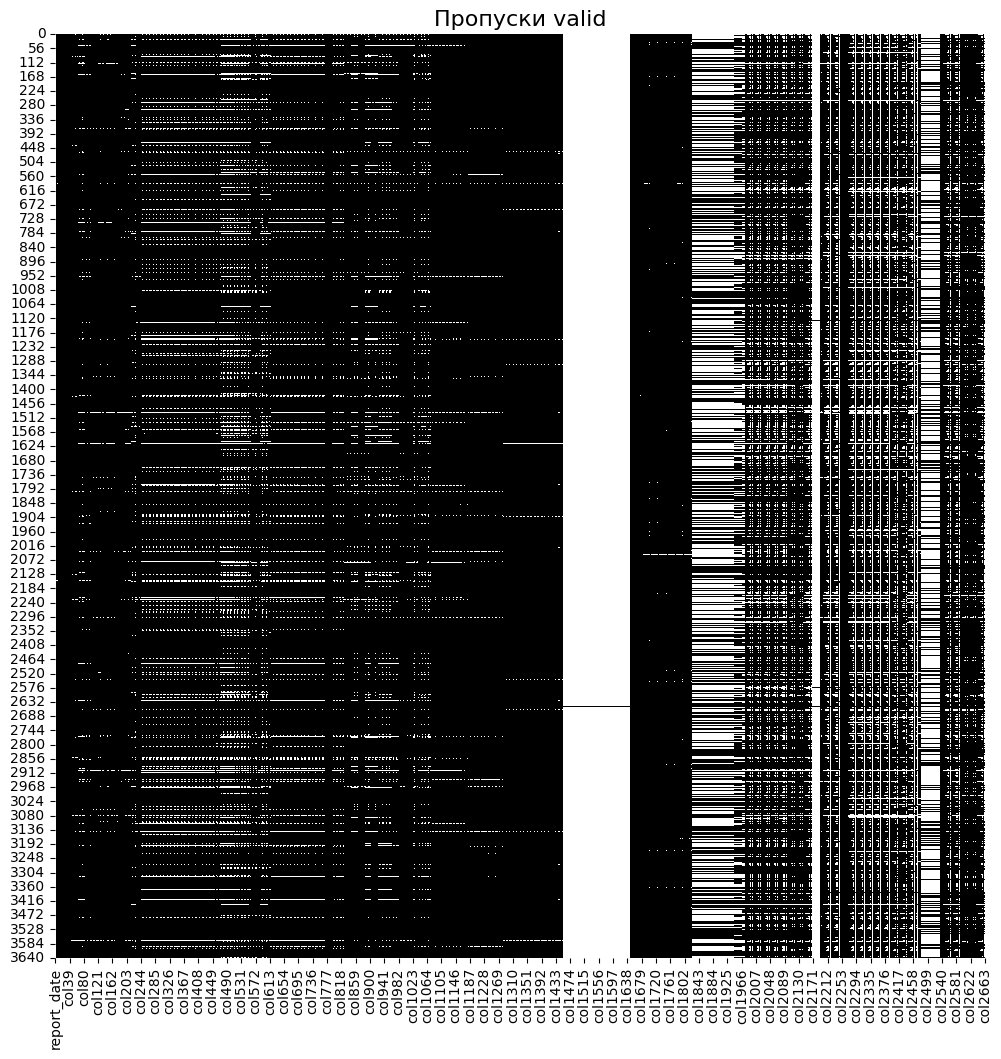

In [279]:
for i, elem in enumerate(arr): 
      fig, ax = plt.subplots(figsize=(12, 12))
      sns.heatmap(elem.isnull(), cbar = False, cmap = 'Greys')
      plt.title(f"Пропуски {names_df[i]}", fontsize=16)
      plt.show()

Обработка (IQR межквартильный размах)

In [280]:
def iqr_remove(df, columns=None, threshold=3):
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns
    
    df_clean = df.copy()
    for col in columns:
            Q1 = df[col].quantile(0.25)  
            Q3 = df[col].quantile(0.75)  
            IQR = Q3 - Q1  
        
            lower_bound = Q1 - threshold * IQR  
            upper_bound = Q3 + threshold * IQR
        
            # Фильтрация данных: оставить только значения в допустимых пределах
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

for i, elem in enumerate(arr):
    # Удаление аномалий из всех числовых столбцов
    cleaned = iqr_remove(elem)

    # Проверка результатов
    print(f"{names_df[i]} до удаления аномалий:", elem.shape)
    print(f"{names_df[i]} после удаления аномалий:", cleaned.shape)

    cleaned.to_csv(f'df/_{names_df[i]}_updt.csv', index=False)
    print("Данные успешно сохранены.")

    perenos()

train до удаления аномалий: (14456, 2666)
train после удаления аномалий: (0, 2666)
Данные успешно сохранены.

*******************************************************************************

valid до удаления аномалий: (3642, 2666)
valid после удаления аномалий: (0, 2666)
Данные успешно сохранены.


In [281]:
train.head(5)

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2022-11-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
1,2022-11-01,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7616803.0,7616803.0,7616803.0,NaN,NaN,NaN,7616803.0,7616803.0,7616803.0,0.256261
2,2022-05-01,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
3,2022-09-01,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258682
4,2022-08-01,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254164


In [282]:
valid.head(5)

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2023-04-01,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4941670.0,4941670.0,4941670.0,NaN,NaN,NaN,4941670.0,4941670.0,4941670.0,0.256919
1,2023-05-01,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11789500.0,11789500.0,11789500.0,NaN,NaN,NaN,11789500.0,11789500.0,11789500.0,0.267221
2,2023-05-01,9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7000000.0,7000000.0,7000000.0,NaN,NaN,NaN,7000000.0,7000000.0,7000000.0,0.257217
3,2023-03-01,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
4,2023-03-01,14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10391000.0,10391000.0,10391000.0,0.257348


In [283]:
# Проверка, совпадают ли структуры
def check_struktura(arr):
    if sorted(arr[0].columns) != sorted(arr[1].columns):
        raise ValueError("Структуры не совпадают!")
    else:
        print("Структуры совпадают.")

threshold = 0.75

# Рассчитаем долю пропусков
train_missing_fraction = train.isnull().mean()
valid_missing_fraction = valid.isnull().mean()

# Рассчитаем максимальную долю пропусков
combined_missing_fraction = pd.concat([train_missing_fraction, valid_missing_fraction], axis=1).max(axis=1)

# Определяем колонки для удаления
columns_to_drop = []
for col in combined_missing_fraction.index:
    if combined_missing_fraction[col] > threshold:
        columns_to_drop.append(col)

# Удаляем колонки с большим количеством пропусков
train_updt = train.drop(columns=columns_to_drop)
valid_updt = valid.drop(columns=columns_to_drop)

arr_updt = [train_updt, valid_updt]
names_df_updt = ['train_cleaned', 'valid_cleaned']

check_struktura(arr)
print()

# Проверка наличия одновременно float и object
def has_mixed_types(column):
    types = set(column.dropna().map(type))
    return float in types and str in types

# Определяем колонки с разными типами данных
for i, elem in enumerate(arr_updt):
    mixed_type_columns = []
    for col in elem.columns:
        if has_mixed_types(elem[col]):
            mixed_type_columns.append(col)

    if names_df_updt[i] == 'train_cleaned':
        mixed_type_columns_train = mixed_type_columns
    else:
        mixed_type_columns_valid = mixed_type_columns

# Удаляем эти колонки из обоих наборов данных
columns_to_drop_mixed = set(mixed_type_columns_train).union(mixed_type_columns_valid)
train_cleaned = train_updt.drop(columns=columns_to_drop_mixed)
valid_cleaned = valid_updt.drop(columns=columns_to_drop_mixed)

check_struktura(arr_updt)

for i, elem in enumerate(arr_updt):
    print(f"\n{names_df_updt[i]} имеет: {elem.shape} (строк, столбцов)")

Структуры совпадают.

Структуры совпадают.

train_cleaned имеет: (14456, 490) (строк, столбцов)

valid_cleaned имеет: (3642, 490) (строк, столбцов)


In [284]:
for i, elem in enumerate(arr_updt):
    for col in elem.columns:
        if elem[col].dtype in ['float64', 'int64']:
            elem[col] = elem[col].fillna(elem[col].median()) # Заполнение медианой
        elif elem[col].dtype == 'object':
            elem[col] = elem[col].fillna('unknown') # Заполнение unknown

check_struktura(arr_updt)

for i, elem in enumerate(arr_updt):
    elem.to_csv(f'df/__{names_df_updt[i]}.csv', index=False)
    print("Данные успешно сохранены.")

Структуры совпадают.
Данные успешно сохранены.
Данные успешно сохранены.


In [285]:
train_updt.head(3)

,report_date,client_id,target,col1453,col1454,col1455,col1456,col1457,col1458,col1459,...,col2588,col2589,col2590,col2654,col2655,col2656,col2660,col2661,col2662,col2663
0,2022-11-01,1,0,0,00f3d719-a6ec-4960-ba01-8372eb705443,0.0,0.0,0.0,0.0,0.0,...,242.0,242.0,242.0,6240000.0,6164000.0,6224000.0,6244578.0,6146773.5,6225550.0,0.256261
1,2022-11-01,5,0,1,01febac0-b083-494e-8589-f98400074b94,0.0,0.0,0.0,0.0,0.0,...,362.0,362.0,362.0,7616803.0,7616803.0,7616803.0,7616803.0,7616803.0,7616803.0,0.256261
2,2022-05-01,6,0,0,0278175e-c0bb-4e1e-bfe5-20db6811d3e2,0.0,0.0,0.0,0.0,1.0,...,242.0,242.0,242.0,6240000.0,6164000.0,6224000.0,6244578.0,6146773.5,6225550.0,0.256261


In [286]:
valid_updt.head(3)

,report_date,client_id,target,col1453,col1454,col1455,col1456,col1457,col1458,col1459,...,col2588,col2589,col2590,col2654,col2655,col2656,col2660,col2661,col2662,col2663
0,2023-04-01,2,0,0,01016bd5-10dc-ec11-b823-005056b825cd,0.0,0.0,0.0,0.0,0.0,...,240.0,240.0,240.0,4941670.0,4941670.0,4941670.0,4941670.0,4941670.0,4941670.0,0.256919
1,2023-05-01,4,0,0,0151dccf-0ecb-ed11-b828-005056b81dee,0.0,0.0,1.0,1.0,1.0,...,360.0,360.0,360.0,11789500.0,11789500.0,11789500.0,11789500.0,11789500.0,11789500.0,0.267221
2,2023-05-01,9,0,0,074ce8a6-859a-4084-a1c6-41343a94a856,0.0,0.0,0.0,0.0,0.0,...,348.0,348.0,348.0,7000000.0,7000000.0,7000000.0,7000000.0,7000000.0,7000000.0,0.257217


Смотрим значения после обработки.

In [287]:
for i, elem in enumerate(arr_updt):
    print(f"Число пропущенных значений в датасете {names_df[i]} после обработки:")
    print(elem.isna().sum())
    print(f"\nДатасет {names_df[i]} после обработки имеет: {elem.shape}")
    
    perenos()

Число пропущенных значений в датасете train после обработки:
report_date    0
client_id      0
target         0
col1453        0
col1454        0
              ..
col2656        0
col2660        0
col2661        0
col2662        0
col2663        0
Length: 490, dtype: int64

Датасет train после обработки имеет: (14456, 490)

*******************************************************************************

Число пропущенных значений в датасете valid после обработки:
report_date    0
client_id      0
target         0
col1453        0
col1454        0
              ..
col2656        0
col2660        0
col2661        0
col2662        0
col2663        0
Length: 490, dtype: int64

Датасет valid после обработки имеет: (3642, 490)


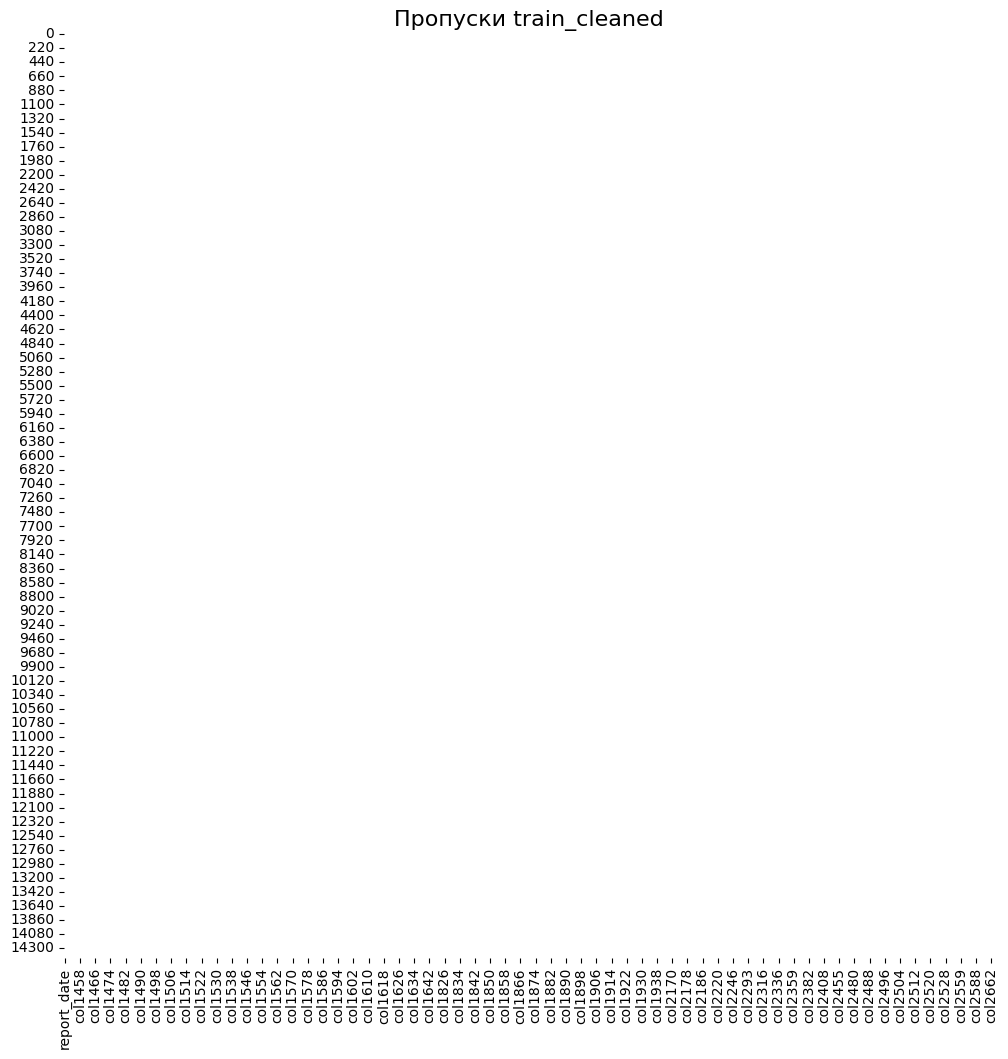

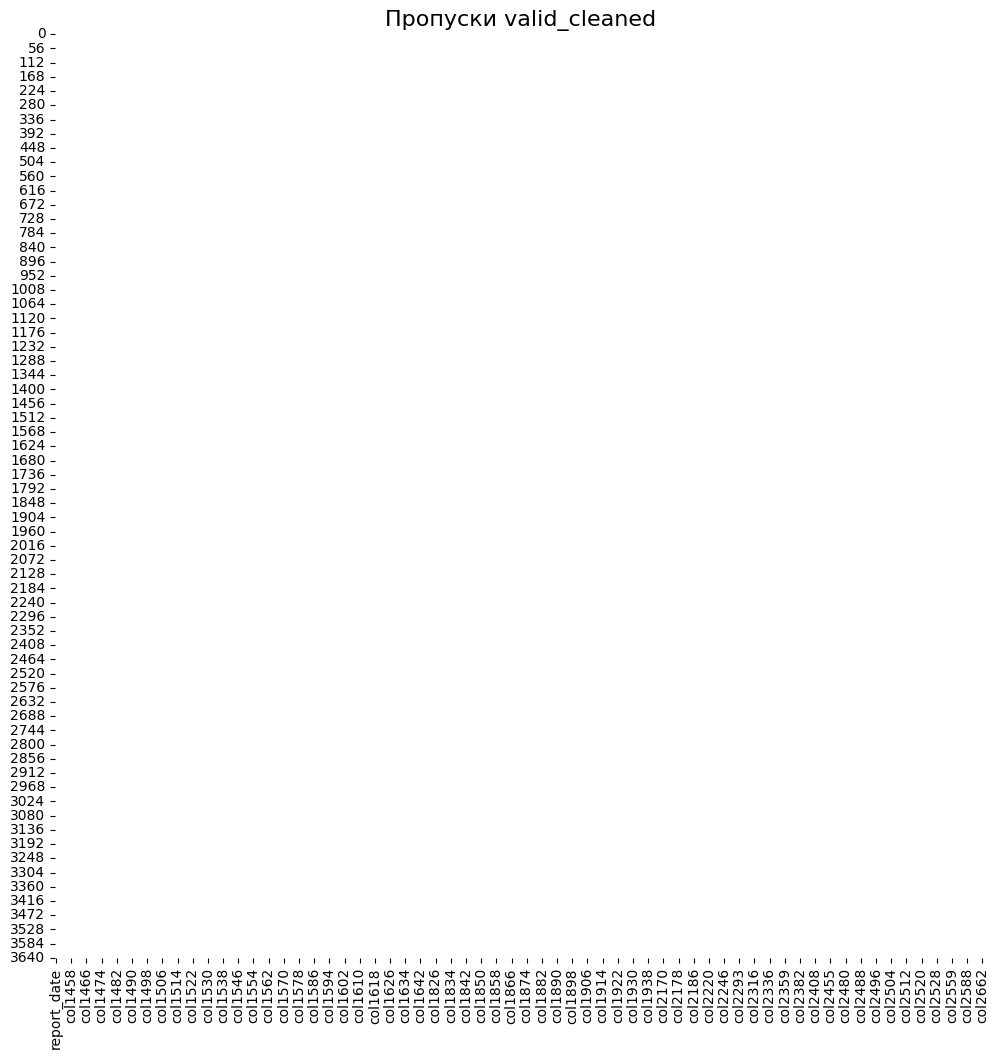

In [288]:
for i, elem in enumerate(arr_updt): 
      fig, ax = plt.subplots(figsize=(12, 12))
      sns.heatmap(elem.isnull(), cbar = False, cmap = 'Greys')
      plt.title(f"Пропуски {names_df_updt[i]}", fontsize=16)
      plt.show()

Подготовка данных для обучения

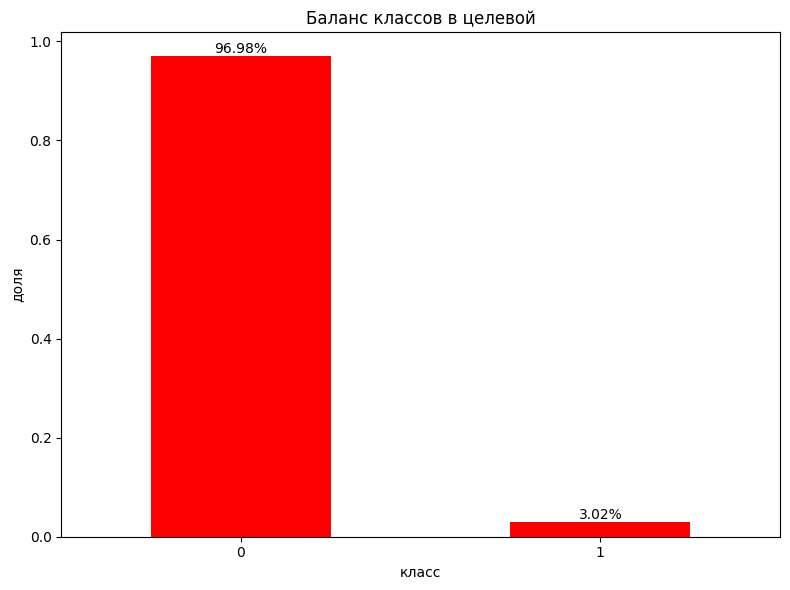

In [289]:
# баланс классов в train

numeric_df_train = train_cleaned.drop(columns=["report_date", "col1454"])
numeric_df_valid = valid_cleaned.drop(columns=["report_date", "col1454"])

# признаки и целевая
X_train = numeric_df_train.drop(columns=['target', 'client_id'])
y_train = train_cleaned['target']

class_balance = y_train.value_counts(normalize=True)

# Визуализация
plt.figure(figsize=(8, 6))
class_balance.plot(kind='bar', color='red')
plt.title('Баланс классов в целевой')
plt.xlabel('класс')
plt.ylabel('доля')
plt.xticks(rotation=0)
for f, e in enumerate(class_balance):
    plt.text(f, e, f'{e:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [290]:
# Производим балансировку классов с помощью SMOTETomek
from imblearn.combine import SMOTETomek

# Создаем объект SMOTE
smote = SMOTETomek(random_state=42)

# Применяем SMOTE
X_balanced_train, y_balanced_train = smote.fit_resample(X_train, y_train)

class_balance = y_balanced_train.value_counts(normalize=True)

# Проверяем баланс
print("Баланс после SMOTE:")
print(y_balanced_train.value_counts(normalize=True))

# Визуализация
plt.figure(figsize=(8, 6))
class_balance.plot(kind='bar', color='red')
plt.title('Баланс классов в целевой')
plt.xlabel('класс')
plt.ylabel('доля')
plt.xticks(rotation=0)
for f, e in enumerate(class_balance):
    plt.text(f, e, f'{e:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

c:\Users\Andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTETomek or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


ValueError: Input X contains NaN.
SMOTETomek does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values